In [1]:
using POMDPs, POMDPToolbox
using AutomotiveDrivingModels, AutomotivePOMDPs
using ProgressMeter
using ProfileView
using Traceur

11-Aug 18:32:15:WARNING:root:replacing docs for 'AutomotivePOMDPs.scene_to_states :: Tuple{Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotivePOMDPs.SingleOCPOMDP}' in module 'AutomotivePOMDPs'.
11-Aug 18:32:20:WARNING:root:replacing docs for 'AutomotivePOMDPs.states_to_scene :: Tuple{Dict{Int64,AutomotivePOMDPs.SingleOCState},AutomotivePOMDPs.SingleOCPOMDP}' in module 'AutomotivePOMDPs'.


In [2]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

In [9]:
mdp = PedCarMDP(env=env, pos_res=2.0, vel_res=2.);

In [10]:
# state_space = states(mdp);
action_space = actions(mdp)

4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [5]:
# for s in state_space 
#     mdp._collision_checker[(s.ego, s.car, s.ped)] = AutomotivePOMDPs.crash(mdp, s.ego, s.car, s.ped)
# end

In [11]:
rng = MersenneTwister(2);

In [14]:
Profile.clear()

In [18]:
# rng = MersenneTwister(3)
N_SAMPLES = 10000
ns = n_states(mdp)
sampled_states = [AutomotivePOMDPs.ind2state(mdp, si) for si in rand(rng, 1:ns, N_SAMPLES)]
# sampled_states = rand(rng, state_space, N_SAMPLES)
sampled_idx = rand(rng, 1:ns, N_SAMPLES)

function test_transition(mdp, sampled_states, action_space, rng, n)
    a = 0
    for (i, si) in enumerate(sampled_states)
          s = AutomotivePOMDPs.ind2state(mdp, si) 
          d = transition(mdp, s, rand(rng, action_space))
#           a += length(d.vals)
    end# 2e-3s
    return a
end

@time  a = test_transition(mdp, sampled_idx, action_space, rng, N_SAMPLES)
a/N_SAMPLES

  0.789110 seconds (7.48 M allocations: 495.191 MiB, 14.99% gc time)


0.0

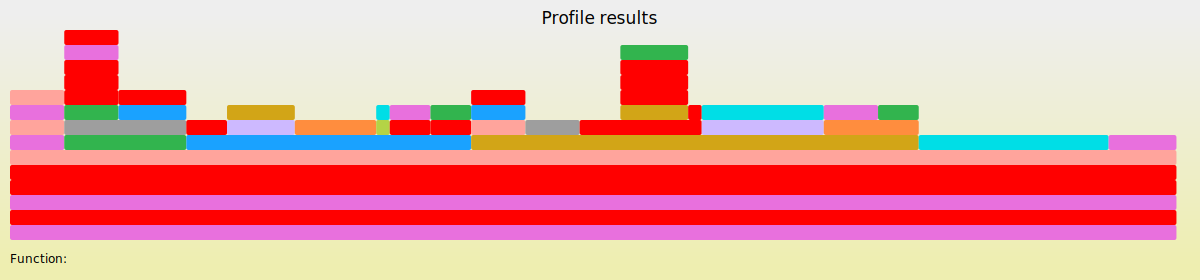

In [16]:
ProfileView.view()

In [9]:
function get_distance_to_crosswalk2(model::CrosswalkDriver, veh::VehicleState, roadway::Roadway, delta::Float64 = 0.)
    lane = get_lane(roadway, veh)
    Δs = 0.
    if lane ∈ model.intersection_entrances # stop before the intersection to not block traffic
        Δs = get_end(lane) - veh.posF.s + delta - model.crosswalk.width
    elseif lane ∈ model.conflict_lanes
        cw_length = get_end(model.crosswalk)
        cw_start = model.crosswalk.curve[1].pos
        cw_center = get_posG(Frenet(model.crosswalk, cw_length/2), roadway)
        cw_to_car = ego.posG - cw_center 
        car_vec = polar(1., ego.posG.θ) - ego.posG + ego.posG
        d = dot(car_vec, cw_to_car)
        Δs = d + delta - model.crosswalk.width/2
    end
    return Δs
end

get_distance_to_crosswalk2 (generic function with 2 methods)

## Dictionary implementation

In [2]:
using StaticArrays
using GridInterpolations
using POMDPs
using POMDPToolbox
using AutomotiveDrivingModels
using AutoViz
using Reel
using AutomotivePOMDPs
using PedCar
using ProfileView
using ProgressMeter

In [3]:
mdp = PedCar.PedCarMDP(pos_res = 2.0, vel_res=2.0)
init_transition!(mdp);
# init_collision_checker!(mdp)

In [4]:
rng = MersenneTwister(1)
action_space = actions(mdp)

4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [28]:
Profile.clear()

In [31]:
# rng = MersenneTwister(3)
N_SAMPLES = 10000
ns = n_states(mdp)
sampled_states = [PedCar.ind2state(mdp, si) for si in rand(rng, 1:ns, N_SAMPLES)]
# sampled_states = rand(rng, state_space, N_SAMPLES)
sampled_idx = rand(rng, 1:ns, N_SAMPLES)

function test_transition(mdp, sampled_states, action_space, rng, n)
    a = 0
    max_a = 0
    for (i, si) in enumerate(sampled_states)
           s = @profile s = PedCar.ind2state(mdp, si) 
           @profile d = transition(mdp, s, rand(rng, action_space))
#           a += length(d.vals)
#           if length(d.vals) > max_a
#             max_a = length(d.vals)
#           end
    end# 2e-3s
    return a, max_a
end

@time a, max_a = test_transition(mdp, sampled_idx, action_space, rng, N_SAMPLES)
a/N_SAMPLES, max_a

  0.559954 seconds (1.71 M allocations: 257.565 MiB, 10.83% gc time)


(0.0, 0)

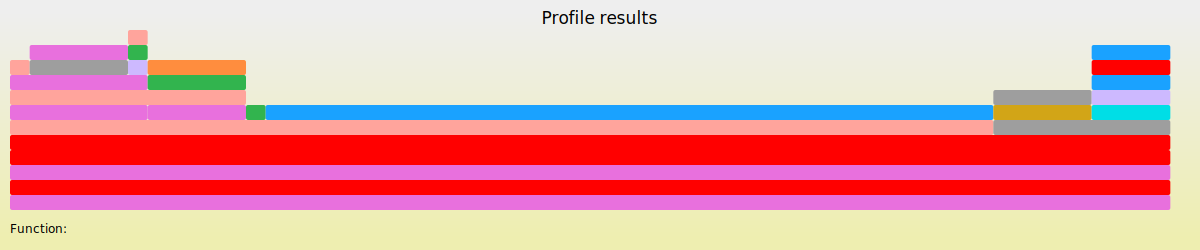

In [30]:
ProfileView.view()

In [88]:
function test_index(mdp::PedCarMDP, state_space::Vector{PedCarMDPState})
    @showprogress for (i, s) in enumerate(state_space) 
        si = stateindex(mdp, s)
        if si != i
            println("bug for $i, index is $si")
            break
        end
    end
end

mdp = PedCarMDP(pos_res=3.0)

n_states(mdp)

@time state_space = states(mdp);

 33.962964 seconds (125.33 M allocations: 4.646 GiB, 10.43% gc time)


In [54]:
test_index(mdp, state_space)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


In [ ]:
@showprogress for (i, s) in enumerate(state_space)
    @assert ind2state(mdp, i) == s println(i)
end

Progress:  72%|█████████████████████████████            |  ETA: 0:00:37

In [57]:
s = state_space[109573]

PedCar.PedCarMDPState(true, VehicleState(VecSE2({1.500, -6.000}, 1.571), Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({2.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.642857}, {19, 1}), 9.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.000000}, {1, 1}), 0.000, 0.000, 0.000), 0.000), AutomotiveDrivingModels.LaneTag[LaneTag(1, 1), LaneTag(2, 1)])

In [66]:
ss = ind2state(mdp, 109573)

PedCar.PedCarMDPState(false, VehicleState(VecSE2({NaN, NaN}, NaN), Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({NaN, NaN}, NaN), Frenet(RoadIndex({1, 0.642857}, {19, 1}), 9.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({NaN, NaN}, NaN), Frenet(RoadIndex({1, 0.000000}, {1, 1}), 0.000, 0.000, 0.000), 0.000), AutomotiveDrivingModels.LaneTag[LaneTag(1, 1), LaneTag(2, 1)])

In [65]:
crash(mdp, s.ego, s.car, s.ped)

true

In [47]:
s.crash

true

In [48]:
ss.crash

false

In [61]:
s.ego == ss.ego && s.ped == ss.ped && s.car == ss.car && s.route == ss.route

true

In [14]:
rand_pol = solve(RandomSolver(), mdp);
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
@time hist2 = simulate(hr, mdp, rand_pol, s0);

  0.001873 seconds (8.01 k allocations: 1.620 MiB)


In [15]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist)
speed_factor = 3
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpdEcSyf", 0x0000000000000059, 6.0, nothing)

In [80]:
s = hist2.state_hist[2].ego

VehicleState(VecSE2({0.143, 0.000}, 0.000), Frenet(RoadIndex({4611686018427387904, 0.000000}, {4614256656552045848, 4611686018427387904}), 6.000, -3.000, 1.571), 0.000)

In [77]:
a = hist2.action_hist[1]

AutomotivePOMDPs.UrbanAction(2.0)

In [78]:
mdp._ego_transition_dict[(s.ego, LonAccelDirection(2.0, 4))]

POMDPToolbox.SparseCat{Array{AutomotiveDrivingModels.VehicleState,1},Array{Float64,1}}(AutomotiveDrivingModels.VehicleState[VehicleState(VecSE2({1.500, -10.000}, 1.571), Frenet(RoadIndex({1, 0.769231}, {6, 1}), 20.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({1.500, -8.000}, 1.571), Frenet(RoadIndex({1, 0.846154}, {6, 1}), 22.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({1.500, -10.000}, 1.571), Frenet(RoadIndex({1, 0.769231}, {6, 1}), 20.000, 0.000, 0.000), 2.000), VehicleState(VecSE2({1.500, -8.000}, 1.571), Frenet(RoadIndex({1, 0.846154}, {6, 1}), 22.000, 0.000, 0.000), 2.000)], [0.4375, 0.0625, 0.4375, 0.0625])

In [64]:
i = 1
for (k, v) in mdp._ego_transition_dict
    if i==800
        for (vv, p) in weighted_iterator(v)
            println(vv)
        end
        break
    end
    i += 1
end

VehicleState(VecSE2({1.500, -28.000}, 1.571), Frenet(RoadIndex({1, 0.076923}, {6, 1}), 2.000, 0.000, 0.000), 0.000)
VehicleState(VecSE2({1.500, -26.000}, 1.571), Frenet(RoadIndex({1, 0.153846}, {6, 1}), 4.000, 0.000, 0.000), 0.000)
